In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np 
import matplotlib.pyplot as plt
import cv2 
import matplotlib

In [2]:
# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [23]:
# Build the CNN model
model = models.Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
750/750 [==============================] - 8s 10ms/step - loss: 0.5231 - accuracy: 0.8361 - val_loss: 0.1899 - val_accuracy: 0.9443
Epoch 2/5
750/750 [==============================] - 7s 10ms/step - loss: 0.1655 - accuracy: 0.9502 - val_loss: 0.1135 - val_accuracy: 0.9654
Epoch 3/5
750/750 [==============================] - 7s 9ms/step - loss: 0.1116 - accuracy: 0.9654 - val_loss: 0.1008 - val_accuracy: 0.9704
Epoch 4/5
750/750 [==============================] - 7s 10ms/step - loss: 0.0882 - accuracy: 0.9730 - val_loss: 0.0807 - val_accuracy: 0.9757
Epoch 5/5
750/750 [==============================] - 8s 10ms/step - loss: 0.0761 - accuracy: 0.9761 - val_loss: 0.0780 - val_accuracy: 0.9766


In [24]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

  1/313 [..............................] - ETA: 0s - loss: 0.0164 - accuracy: 1.0000

313/313 [==============================] - 1s 4ms/step - loss: 0.0697 - accuracy: 0.9777
Test accuracy: 0.9776999950408936


In [25]:
# Save the model
model.save('../models/mnist_cnn_model.h5')

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 16)        1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 16)          2320      
_________________________________________________________________
flatten_1 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)               

In [7]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        # print(preds.shape, last_conv_layer_output.shape)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
            # print(pred_index)
        
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    # print(grads.shape)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # print(pooled_grads.shape)

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    # print(heatmap.shape)
    heatmap = tf.squeeze(heatmap)
    # print(heatmap.shape)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    # jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    # print(jet_heatmap.shape)
    # jet_heatmap = im.fromarray(jet_heatmap) 
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[0], img.shape[1]))

    return jet_heatmap

In [8]:
test_images[0].max()

1.0

Predicted: 4


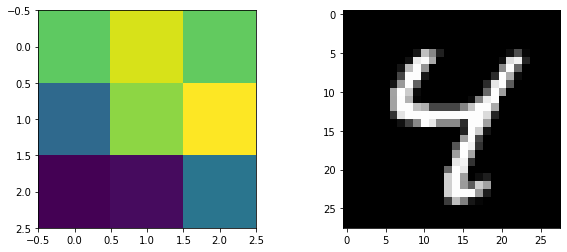

In [10]:
last_conv_layer_name = 'conv2d_2'

# img_array = get_img_array(test_image_folder_path+L[0], size=(image_height, image_width)) 
img_array = np.array([test_images[6]])#+np.random.normal(0, 0.05, test_images[0].shape)])

# Make model
# model = model_builder(weights="imagenet")

# Remove last layer's softmax
# classification_model.layers[-1].activation = None

# Print what the top predicted class is

preds = model.predict(img_array)
pred_index = np.argmax(preds)
print("Predicted:", pred_index)


# # Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=pred_index)

jet_heatmap = save_and_display_gradcam(img_array[0], heatmap, cam_path="cam.jpg", alpha=0.4)
# print(heatmap)
# Display heatmap

fig, axs = plt.subplots(1, 2, figsize=(10, 4)) 

axs[0].imshow(heatmap)
# plt.show()

axs[1].imshow(img_array[0][:, :, 0], cmap='gray')
plt.show()

In [11]:
test_labels_int = np.argmax(test_labels, axis=1)
test_labels_int.shape

(10000,)

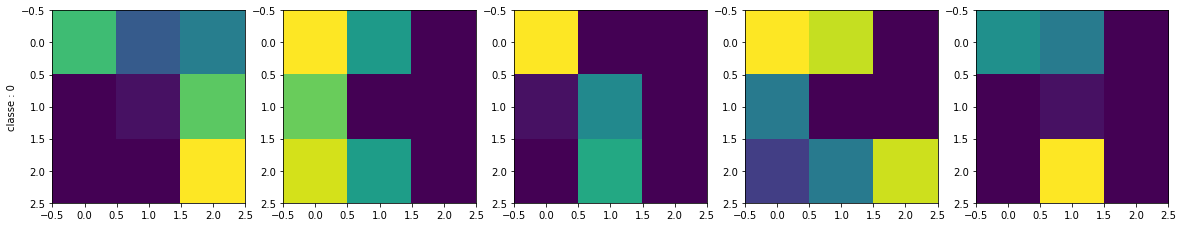

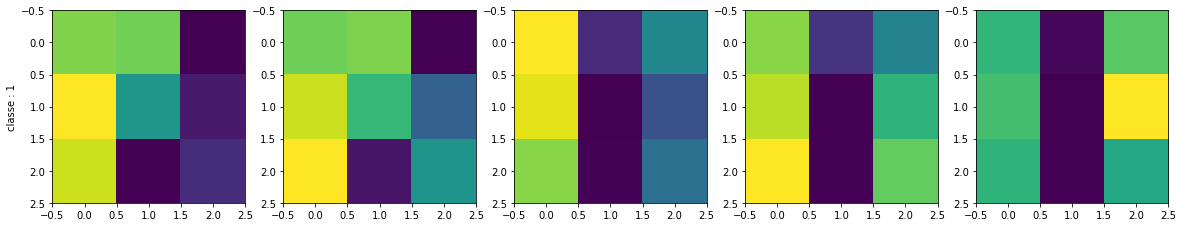

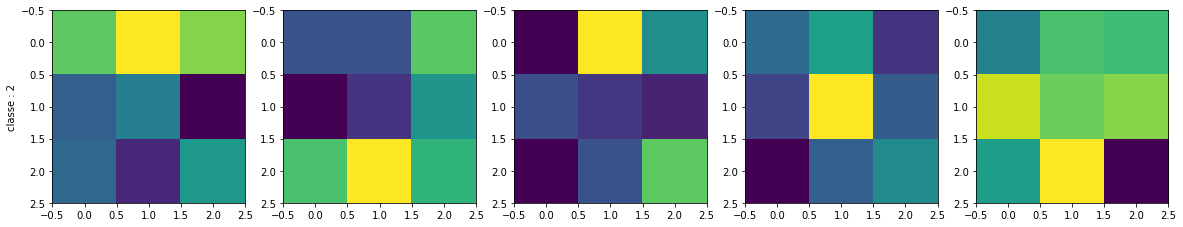

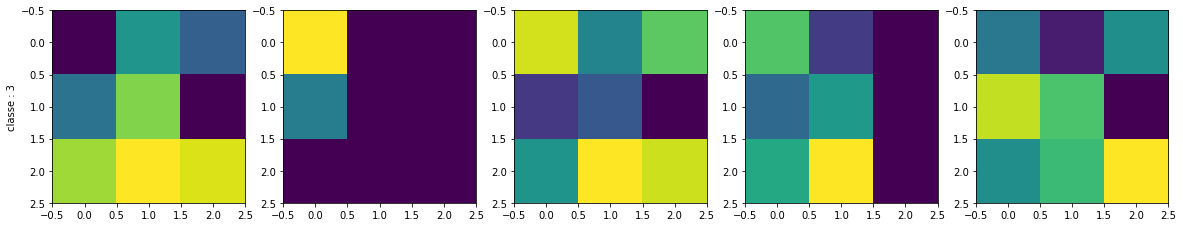

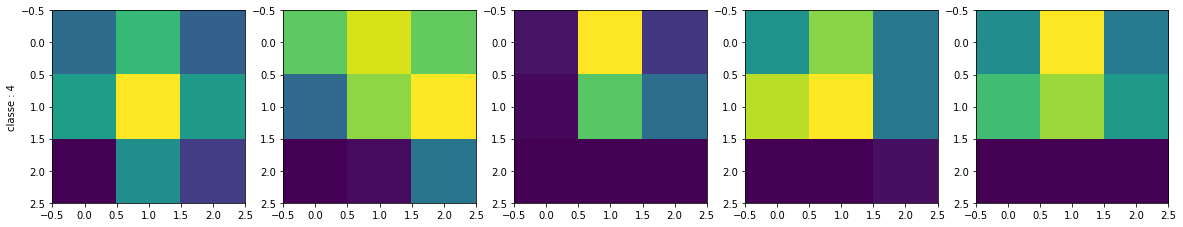

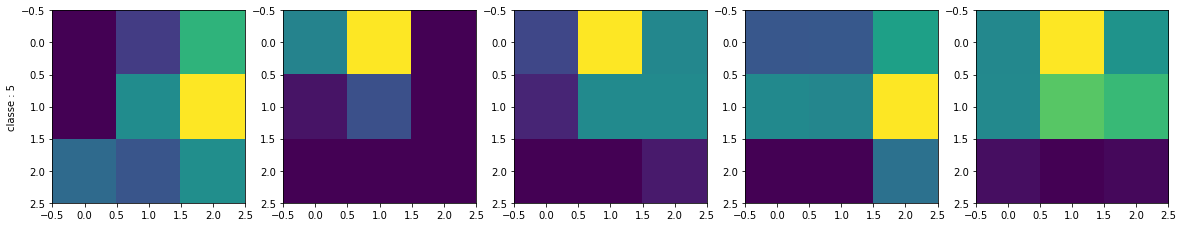

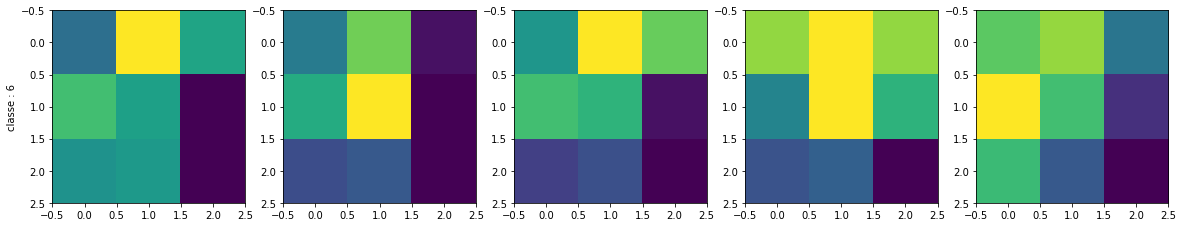

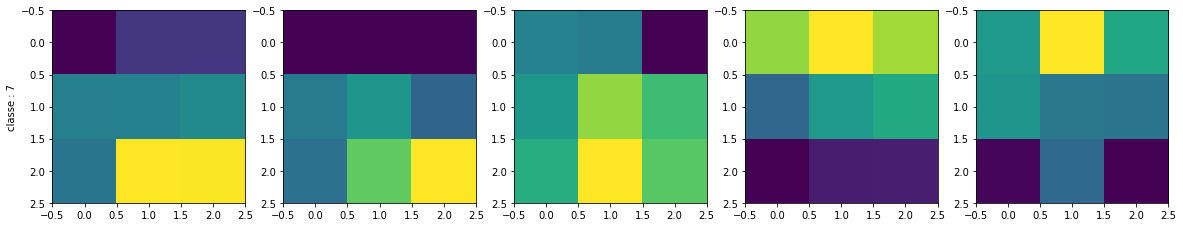

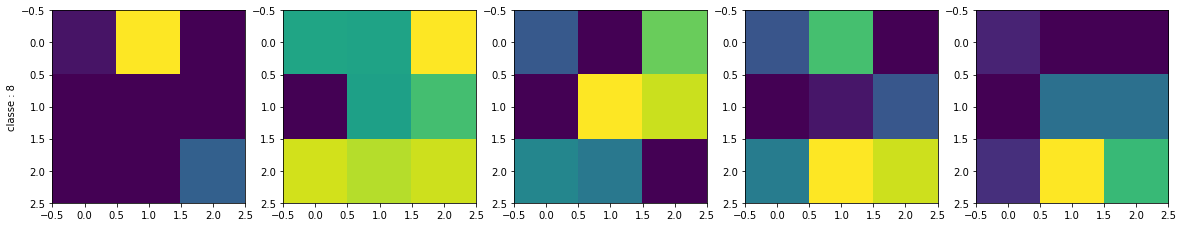

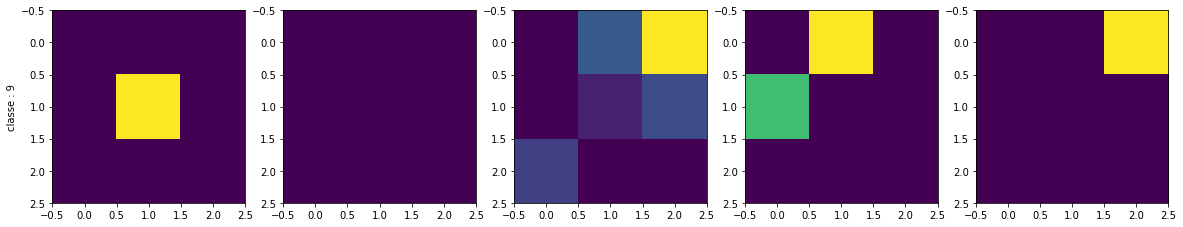

In [12]:
last_conv_layer_name = 'conv2d_2'

for i in range(10) :
    
    fig, axs = plt.subplots(1, 5, figsize=(20, 4)) 
    sample = test_images[test_labels_int==i][:5]
    
    for j in range(5) : 
        
        img_array = sample[j:j+1]
        preds = model.predict(img_array)
        pred_index = np.argmax(preds)
        # print("Predicted:", pred_index)

        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=pred_index)
        axs[j].imshow(heatmap)
        if j==0 :
            axs[j].set_ylabel(f"classe : {i}")
    
    plt.show

In [28]:
conv_layers = ['conv2d_3', 'conv2d_4', 'conv2d_5']

img_array = np.array([test_images[6]])

model_layers = models.Model(model.inputs, [model.get_layer(name).output for name in conv_layers])

out = model_layers(img_array)

for v in out : 
    print(v.shape)

(1, 26, 26, 8)
(1, 11, 11, 16)
(1, 3, 3, 16)


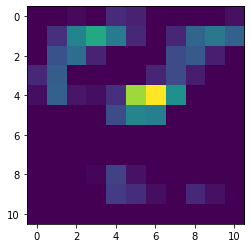

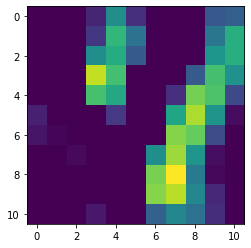

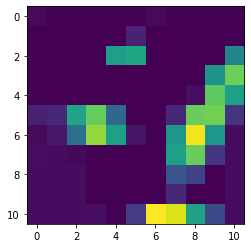

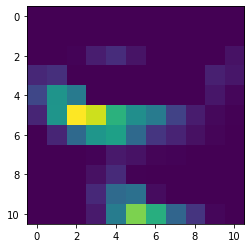

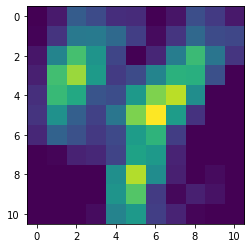

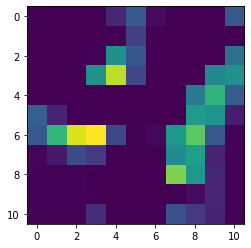

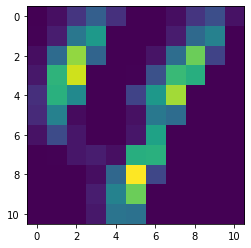

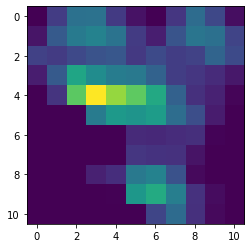

In [30]:
for j in range(8) : 
    plt.imshow(np.array(out[1][0][:, :, j]))
    plt.show()